# Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from datetime import datetime, timedelta
from collections import defaultdict
import glob


## Variables

In [11]:
DATA_FOLDER = 'data'
REGIONS = ['us-east-1']

## Utilities

In [32]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


## Load the Dataset

In [64]:
def get_hourly_price(data):
    hourly_prices = []
    last_price = None
    start_time = data['price_timestamp'].min().replace(minute=0, second=0, microsecond=0)
    end_time = data['price_timestamp'].max().replace(minute=0, second=0, microsecond=0)
    time_range = pd.date_range(start=start_time, end=end_time, freq='h')

    for hour in time_range:
        hourly_data = data[(data['price_timestamp'] >= hour) & (data['price_timestamp'] < hour + timedelta(hours=1))]
        if len(hourly_data) == 0:
            hourly_prices.append([hour, last_price])
        elif len(hourly_data) == 1:
            last_price = hourly_data['spot_price'].values[0]
            hourly_prices.append([hour, last_price])
        else:
            last_price = hourly_data['spot_price'].mean()
            hourly_prices.append([hour, last_price])

    return hourly_prices

In [18]:
for region in REGIONS:
    instance_info_path = f"{DATA_FOLDER}/instance_info_{region}.csv"
    instance_info_df = pd.read_csv(instance_info_path)
    
    prices_files = glob.glob(f"{DATA_FOLDER}/prices_{region}_*.csv")
    prices_df_list = [pd.read_csv(file) for file in prices_files]
    prices_df = pd.concat(prices_df_list, ignore_index=True)

    # Merge the dataframes on id and id_instance
    merged_df = pd.merge(prices_df, instance_info_df, left_on='id_instance', right_on='id')
    
    merged_df['price_timestamp'] = pd.to_datetime(merged_df['price_timestamp'])
    merged_df['modifiers'] = merged_df['modifiers'].fillna('')


    print(merged_df.head())


   id_instance  spot_price           price_timestamp     id     region  \
0        30824      0.2367 2023-09-25 20:02:14+00:00  30824  us-east-1   
1        36201      0.9239 2023-09-25 20:02:14+00:00  36201  us-east-1   
2        16591      0.2606 2023-09-25 20:02:20+00:00  16591  us-east-1   
3        46327      2.4879 2023-09-25 20:02:22+00:00  46327  us-east-1   
4        48260      4.9210 2023-09-25 20:02:23+00:00  48260  us-east-1   

  av_zone  instance_type instance_family  generation modifiers  size  vcpu  \
0       b     c5.2xlarge               c           5             2.0     8   
1       d     i3.8xlarge               i           3             8.0    32   
2       f    r7g.2xlarge               r           7         g   2.0     8   
3       f   c5ad.8xlarge               c           5        ad   8.0    32   
4       b  r5dn.16xlarge               r           5        dn  16.0    64   

     memory architectures product_description  on_demand_price  
0   16384.0    ['x86_

In [67]:
# Load the dataset
folder = 'data'
data = pd.read_csv(file_name)

data.columns = data.columns.str.strip()

# Convert the 'price_timestamp' column to datetime
data['price_timestamp'] = pd.to_datetime(data['price_timestamp'])

instance_prices = defaultdict(list)

# Process the data for each unique 'id'
unique_ids = data['id'].unique()

for unique_id in unique_ids:
    # Filter data for the current 'id'
    id_data = data[data['id'] == unique_id]
    
    # Extract region, av_zone, instance_type, and product_description
    region = id_data['region'].iloc[0]
    av_zone = id_data['av_zone'].iloc[0]
    instance_type = id_data['instance_type'].iloc[0]
    product_description = id_data['product_description'].iloc[0]
    
    instance_tuple = (region, av_zone, instance_type, product_description) 
    instance_prices[instance_tuple] = get_hourly_price(id_data)
    
    instance_prices[instance_tuple] = pd.DataFrame(instance_prices[instance_tuple], columns=['hour', 'spot_price'])

print(instance_prices)


/var/folders/jp/cpljy4z54h1gy2ftctnwqpth0000gn/T/ipykernel_95146/2567429165.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['price_timestamp'] = pd.to_datetime(data['price_timestamp'])


defaultdict(<class 'list'>, {('us-east-1 ', 'd         ', 'c5.9xlarge      ', 'Linux/UNIX            '):                           hour  spot_price
0    2023-09-26 03:00:00+02:00      0.8366
1    2023-09-26 04:00:00+02:00      0.8366
2    2023-09-26 05:00:00+02:00      0.8366
3    2023-09-26 06:00:00+02:00      0.8366
4    2023-09-26 07:00:00+02:00      0.8366
...                        ...         ...
6386 2024-06-18 05:00:00+02:00      0.6642
6387 2024-06-18 06:00:00+02:00      0.6642
6388 2024-06-18 07:00:00+02:00      0.6642
6389 2024-06-18 08:00:00+02:00      0.6642
6390 2024-06-18 09:00:00+02:00      0.6605

[6391 rows x 2 columns]})


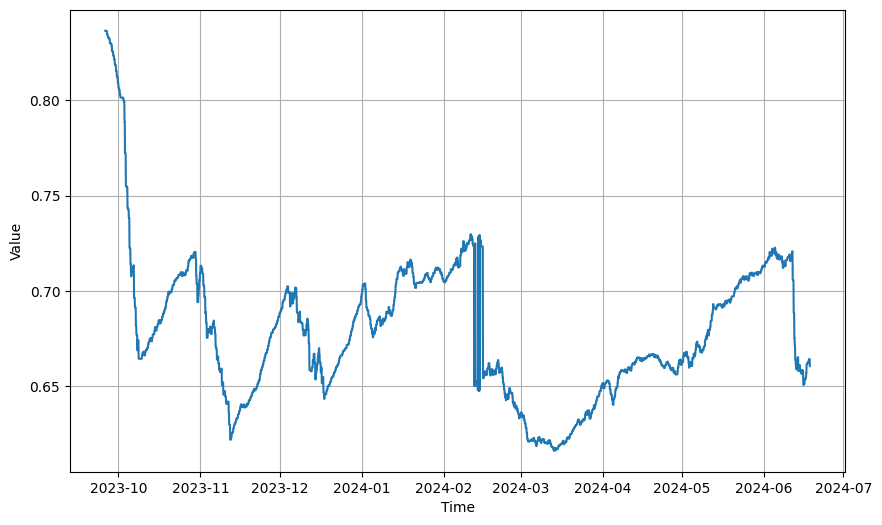

In [35]:
# Extract time and series values
time = hourly_prices_df['hour'].values
series = hourly_prices_df['spot_price'].values

# Plot the results
plot_series(time, series)

In [36]:
# Define the split time
split_time = int(0.8 * len(series))  # Use 80% of the data for training

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [37]:
# Function to create windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [38]:
# Parameters for windowed dataset
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [39]:
# Build the Model
model_tune = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

/Users/adf/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [40]:
# Set the learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.9935 - learning_rate: 1.0000e-08
Epoch 2/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5600

2024-06-19 18:49:33.616118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/adf/.pyenv/versions/3.12.2/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2919 - learning_rate: 1.1220e-08
Epoch 3/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7818

2024-06-19 18:49:35.111005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4975 - learning_rate: 1.2589e-08
Epoch 4/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9009

2024-06-19 18:49:36.586848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6272 - learning_rate: 1.4125e-08
Epoch 5/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2060

2024-06-19 18:49:38.041556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1177 - learning_rate: 1.5849e-08
Epoch 6/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0629

2024-06-19 18:49:39.628198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0301 - learning_rate: 1.7783e-08
Epoch 7/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0326

2024-06-19 18:49:41.132020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0177 - learning_rate: 1.9953e-08
Epoch 8/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0258

2024-06-19 18:49:42.723105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0155 - learning_rate: 2.2387e-08
Epoch 9/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0252

2024-06-19 18:49:44.217722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0152 - learning_rate: 2.5119e-08
Epoch 10/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0323

2024-06-19 18:49:45.722672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - learning_rate: 2.8184e-08
Epoch 11/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0317

2024-06-19 18:49:47.215008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0160 - learning_rate: 3.1623e-08
Epoch 12/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0333

2024-06-19 18:49:48.765692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0160 - learning_rate: 3.5481e-08
Epoch 13/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0255

2024-06-19 18:49:50.212898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0151 - learning_rate: 3.9811e-08
Epoch 14/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0283

2024-06-19 18:49:51.676041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0152 - learning_rate: 4.4668e-08
Epoch 15/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0265

2024-06-19 18:49:53.118933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0154 - learning_rate: 5.0119e-08
Epoch 16/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0279

2024-06-19 18:49:54.579114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - learning_rate: 5.6234e-08
Epoch 17/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0335

2024-06-19 18:49:56.064128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - learning_rate: 6.3096e-08
Epoch 18/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0269

2024-06-19 18:49:57.514010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - learning_rate: 7.0795e-08
Epoch 19/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0335

2024-06-19 18:49:58.954729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0158 - learning_rate: 7.9433e-08
Epoch 20/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0310

2024-06-19 18:50:00.408379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0155 - learning_rate: 8.9125e-08
Epoch 21/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0384

2024-06-19 18:50:01.863776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0163 - learning_rate: 1.0000e-07
Epoch 22/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0328

2024-06-19 18:50:03.301944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - learning_rate: 1.1220e-07
Epoch 23/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0346

2024-06-19 18:50:04.779538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0159 - learning_rate: 1.2589e-07
Epoch 24/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0370

2024-06-19 18:50:06.230572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - learning_rate: 1.4125e-07
Epoch 25/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0265

2024-06-19 18:50:07.674797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0142 - learning_rate: 1.5849e-07
Epoch 26/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0296

2024-06-19 18:50:09.127527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0137 - learning_rate: 1.7783e-07
Epoch 27/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0245

2024-06-19 18:50:10.562998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - learning_rate: 1.9953e-07
Epoch 28/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0327

2024-06-19 18:50:12.063643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0146 - learning_rate: 2.2387e-07
Epoch 29/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0300

2024-06-19 18:50:13.507523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0135 - learning_rate: 2.5119e-07
Epoch 30/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0276

2024-06-19 18:50:14.951650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0133 - learning_rate: 2.8184e-07
Epoch 31/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0302

2024-06-19 18:50:16.392020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - learning_rate: 3.1623e-07
Epoch 32/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0215

2024-06-19 18:50:17.838411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0117 - learning_rate: 3.5481e-07
Epoch 33/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0270

2024-06-19 18:50:19.317053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - learning_rate: 3.9811e-07
Epoch 34/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0216

2024-06-19 18:50:20.758513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - learning_rate: 4.4668e-07
Epoch 35/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0216

2024-06-19 18:50:22.214362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - learning_rate: 5.0119e-07
Epoch 36/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0222

2024-06-19 18:50:23.658285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - learning_rate: 5.6234e-07
Epoch 37/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0189

2024-06-19 18:50:25.100092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - learning_rate: 6.3096e-07
Epoch 38/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0201

2024-06-19 18:50:26.544420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0100 - learning_rate: 7.0795e-07
Epoch 39/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0166

2024-06-19 18:50:28.064700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - learning_rate: 7.9433e-07
Epoch 40/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161

2024-06-19 18:50:29.513173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - learning_rate: 8.9125e-07
Epoch 41/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145

2024-06-19 18:50:30.964361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - learning_rate: 1.0000e-06
Epoch 42/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0148

2024-06-19 18:50:32.420568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - learning_rate: 1.1220e-06
Epoch 43/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0139

2024-06-19 18:50:33.856617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - learning_rate: 1.2589e-06
Epoch 44/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0135

2024-06-19 18:50:35.328303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - learning_rate: 1.4125e-06
Epoch 45/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0126

2024-06-19 18:50:36.764528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - learning_rate: 1.5849e-06
Epoch 46/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079

2024-06-19 18:50:38.206724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - learning_rate: 1.7783e-06
Epoch 47/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092

2024-06-19 18:50:39.638329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - learning_rate: 1.9953e-06
Epoch 48/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064

2024-06-19 18:50:41.085094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - learning_rate: 2.2387e-06
Epoch 49/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060

2024-06-19 18:50:42.585945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - learning_rate: 2.5119e-06
Epoch 50/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044

2024-06-19 18:50:44.021639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - learning_rate: 2.8184e-06
Epoch 51/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051

2024-06-19 18:50:45.460860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - learning_rate: 3.1623e-06
Epoch 52/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033

2024-06-19 18:50:46.909444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - learning_rate: 3.5481e-06
Epoch 53/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031

2024-06-19 18:50:48.340691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - learning_rate: 3.9811e-06
Epoch 54/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 

2024-06-19 18:50:49.768449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - learning_rate: 4.4668e-06
Epoch 55/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015

2024-06-19 18:50:51.231737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6018e-04 - learning_rate: 5.0119e-06
Epoch 56/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012

2024-06-19 18:50:52.693096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7234e-04 - learning_rate: 5.6234e-06
Epoch 57/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8041e-04

2024-06-19 18:50:54.131497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8386e-04 - learning_rate: 6.3096e-06
Epoch 58/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1524e-04

2024-06-19 18:50:55.567147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3839e-04 - learning_rate: 7.0795e-06
Epoch 59/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6711e-04

2024-06-19 18:50:57.004343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6552e-04 - learning_rate: 7.9433e-06
Epoch 60/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2965e-04

2024-06-19 18:50:58.484334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0669e-04 - learning_rate: 8.9125e-06
Epoch 61/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0132e-05

2024-06-19 18:50:59.921537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1654e-05 - learning_rate: 1.0000e-05
Epoch 62/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3615e-05

2024-06-19 18:51:01.355114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1371e-05 - learning_rate: 1.1220e-05
Epoch 63/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0838e-05

2024-06-19 18:51:02.806855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7326e-05 - learning_rate: 1.2589e-05
Epoch 64/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7851e-05

2024-06-19 18:51:04.253270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9203e-05 - learning_rate: 1.4125e-05
Epoch 65/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9595e-05

2024-06-19 18:51:05.725789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1617e-05 - learning_rate: 1.5849e-05
Epoch 66/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4831e-05

2024-06-19 18:51:07.160742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1502e-05 - learning_rate: 1.7783e-05
Epoch 67/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6086e-05

2024-06-19 18:51:08.608676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5318e-05 - learning_rate: 1.9953e-05
Epoch 68/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0804e-05

2024-06-19 18:51:10.051402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.1262e-05 - learning_rate: 2.2387e-05
Epoch 69/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7421e-05

2024-06-19 18:51:11.673615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7142e-05 - learning_rate: 2.5119e-05
Epoch 70/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2054e-05

2024-06-19 18:51:13.127756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1276e-05 - learning_rate: 2.8184e-05
Epoch 71/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8342e-05

2024-06-19 18:51:14.562241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3533e-05 - learning_rate: 3.1623e-05
Epoch 72/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2586e-05

2024-06-19 18:51:16.008829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2635e-05 - learning_rate: 3.5481e-05
Epoch 73/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3778e-05

2024-06-19 18:51:17.451496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2718e-05 - learning_rate: 3.9811e-05
Epoch 74/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9005e-05

2024-06-19 18:51:18.919894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1813e-05 - learning_rate: 4.4668e-05
Epoch 75/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3539e-05

2024-06-19 18:51:20.344662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1658e-05 - learning_rate: 5.0119e-05
Epoch 76/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3739e-04

2024-06-19 18:51:21.801422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9474e-05 - learning_rate: 5.6234e-05
Epoch 77/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8364e-05

2024-06-19 18:51:23.248071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3056e-05 - learning_rate: 6.3096e-05
Epoch 78/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9452e-05

2024-06-19 18:51:24.674451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4413e-05 - learning_rate: 7.0795e-05
Epoch 79/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2370e-04

2024-06-19 18:51:26.140917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9698e-04 - learning_rate: 7.9433e-05
Epoch 80/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097

2024-06-19 18:51:27.590082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0954 - learning_rate: 8.9125e-05
Epoch 81/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0905

2024-06-19 18:51:29.017704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7987 - learning_rate: 1.0000e-04
Epoch 82/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1407

2024-06-19 18:51:30.456535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0330 - learning_rate: 1.1220e-04
Epoch 83/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9652e-05

2024-06-19 18:51:31.906095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5847e-04 - learning_rate: 1.2589e-04
Epoch 84/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0179    

2024-06-19 18:51:33.354605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1398 - learning_rate: 1.4125e-04
Epoch 85/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1780

2024-06-19 18:51:34.819398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6832 - learning_rate: 1.5849e-04
Epoch 86/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6619

2024-06-19 18:51:36.244504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1277 - learning_rate: 1.7783e-04
Epoch 87/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3340e-04

2024-06-19 18:51:37.673989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8307e-04 - learning_rate: 1.9953e-04
Epoch 88/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5564e-05

2024-06-19 18:51:39.117582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6445e-05 - learning_rate: 2.2387e-04
Epoch 89/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0212    

2024-06-19 18:51:40.552385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5503 - learning_rate: 2.5119e-04
Epoch 90/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4277

2024-06-19 18:51:42.046234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3753 - learning_rate: 2.8184e-04
Epoch 91/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3543

2024-06-19 18:51:43.483643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3625 - learning_rate: 3.1623e-04
Epoch 92/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4181

2024-06-19 18:51:44.929136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4596 - learning_rate: 3.5481e-04
Epoch 93/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5613

2024-06-19 18:51:46.358921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6273 - learning_rate: 3.9811e-04
Epoch 94/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7887

2024-06-19 18:51:47.804491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8533 - learning_rate: 4.4668e-04
Epoch 95/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0515 

2024-06-19 18:51:49.243757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1271 - learning_rate: 5.0119e-04
Epoch 96/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3647

2024-06-19 18:51:50.740147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4448 - learning_rate: 5.6234e-04
Epoch 97/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7217

2024-06-19 18:51:52.194024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8041 - learning_rate: 6.3096e-04
Epoch 98/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1217

2024-06-19 18:51:53.629531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2073 - learning_rate: 7.0795e-04
Epoch 99/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5623

2024-06-19 18:51:55.062763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6596 - learning_rate: 7.9433e-04
Epoch 100/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0613

2024-06-19 18:51:56.554477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1663 - learning_rate: 8.9125e-04


2024-06-19 18:51:58.055728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 30.0)

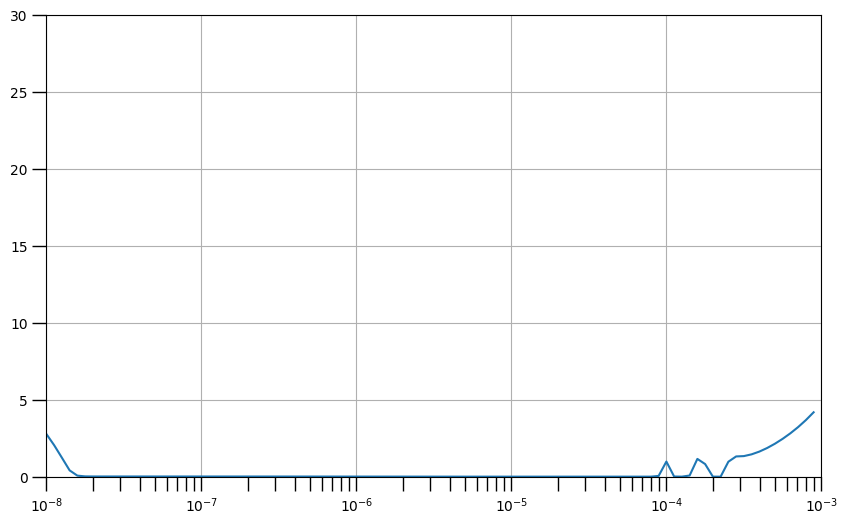

In [41]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [60]:
# Reset states generated by Keras
keras.backend.clear_session()

# Build the model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
  keras.layers.Bidirectional(keras.layers.LSTM(32)),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2924 - mae: 0.5373
Epoch 2/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - mae: 0.0797

2024-06-20 12:33:05.474867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028 - mae: 0.0537 
Epoch 3/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - mae: 0.0652

2024-06-20 12:33:07.039780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0022 - mae: 0.0483
Epoch 4/100
  5/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0049 - mae: 0.0742  

2024-06-20 12:33:08.783088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0021 - mae: 0.0454
Epoch 5/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - mae: 0.0479

2024-06-20 12:33:10.760614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0015 - mae: 0.0389
Epoch 6/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - mae: 0.0483

2024-06-20 12:33:12.456468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0359
Epoch 7/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mae: 0.0503

2024-06-20 12:33:14.052485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0333
Epoch 8/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mae: 0.0456

2024-06-20 12:33:15.589696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.3775e-04 - mae: 0.0306
Epoch 9/100
  6/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - mae: 0.0472 

2024-06-20 12:33:17.314362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.7513e-04 - mae: 0.0293
Epoch 10/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.2015e-04 - mae: 0.0315

2024-06-20 12:33:19.087614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.7089e-04 - mae: 0.0258
Epoch 11/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0343

2024-06-20 12:33:20.655477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0407e-04 - mae: 0.0248
Epoch 12/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8547e-04 - mae: 0.0290

2024-06-20 12:33:22.152936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.8673e-04 - mae: 0.0220
Epoch 13/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6886e-04 - mae: 0.0282

2024-06-20 12:33:23.662099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.7797e-04 - mae: 0.0219
Epoch 14/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6099e-04 - mae: 0.0304

2024-06-20 12:33:25.201210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3200e-04 - mae: 0.0206
Epoch 15/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6197e-04 - mae: 0.0261

2024-06-20 12:33:26.686417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.4828e-04 - mae: 0.0185
Epoch 16/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0479e-04 - mae: 0.0220

2024-06-20 12:33:28.258702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0626e-04 - mae: 0.0170
Epoch 17/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1332e-04 - mae: 0.0192

2024-06-20 12:33:29.786605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.6922e-04 - mae: 0.0159
Epoch 18/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5557e-04 - mae: 0.0210

2024-06-20 12:33:31.350082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6435e-04 - mae: 0.0157
Epoch 19/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1779e-04 - mae: 0.0199

2024-06-20 12:33:32.845711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.3559e-04 - mae: 0.0148
Epoch 20/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1321e-04 - mae: 0.0198

2024-06-20 12:33:34.362716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2498e-04 - mae: 0.0144
Epoch 21/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5814e-04 - mae: 0.0178

2024-06-20 12:33:35.860472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1117e-04 - mae: 0.0137
Epoch 22/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2597e-04 - mae: 0.0162

2024-06-20 12:33:37.421764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8814e-04 - mae: 0.0128
Epoch 23/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5427e-04 - mae: 0.0184

2024-06-20 12:33:38.954400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9138e-04 - mae: 0.0131
Epoch 24/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0806e-04 - mae: 0.0161

2024-06-20 12:33:40.500866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7673e-04 - mae: 0.0123
Epoch 25/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7988e-04 - mae: 0.0150

2024-06-20 12:33:41.999481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7183e-04 - mae: 0.0120
Epoch 26/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1997e-04 - mae: 0.0165

2024-06-20 12:33:43.504589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7400e-04 - mae: 0.0119
Epoch 27/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7020e-04 - mae: 0.0147

2024-06-20 12:33:44.996930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5695e-04 - mae: 0.0114
Epoch 28/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8027e-04 - mae: 0.0142

2024-06-20 12:33:46.578590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6349e-04 - mae: 0.0114
Epoch 29/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1036e-04 - mae: 0.0174

2024-06-20 12:33:48.163733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6432e-04 - mae: 0.0119
Epoch 30/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5516e-04 - mae: 0.0133

2024-06-20 12:33:49.712246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6050e-04 - mae: 0.0114
Epoch 31/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7147e-04 - mae: 0.0143

2024-06-20 12:33:51.214342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6303e-04 - mae: 0.0115
Epoch 32/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6121e-04 - mae: 0.0134

2024-06-20 12:33:52.754805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4853e-04 - mae: 0.0108
Epoch 33/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5355e-04 - mae: 0.0131

2024-06-20 12:33:54.351042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4662e-04 - mae: 0.0106
Epoch 34/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6020e-04 - mae: 0.0133

2024-06-20 12:33:55.880246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4828e-04 - mae: 0.0107
Epoch 35/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6576e-04 - mae: 0.0143

2024-06-20 12:33:57.378919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5757e-04 - mae: 0.0113
Epoch 36/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8894e-04 - mae: 0.0155

2024-06-20 12:33:58.988625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5073e-04 - mae: 0.0110
Epoch 37/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5245e-04 - mae: 0.0143

2024-06-20 12:34:00.632376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4687e-04 - mae: 0.0108
Epoch 38/100
  7/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3720e-04 - mae: 0.0116 

2024-06-20 12:34:02.124679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4462e-04 - mae: 0.0105
Epoch 39/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4771e-04 - mae: 0.0136

2024-06-20 12:34:03.726249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4586e-04 - mae: 0.0108
Epoch 40/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5631e-04 - mae: 0.0129

2024-06-20 12:34:05.200749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4852e-04 - mae: 0.0108
Epoch 41/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5765e-04 - mae: 0.0127

2024-06-20 12:34:06.694743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4938e-04 - mae: 0.0107
Epoch 42/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6143e-04 - mae: 0.0131

2024-06-20 12:34:08.421876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4813e-04 - mae: 0.0107
Epoch 43/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4620e-04 - mae: 0.0121

2024-06-20 12:34:09.997766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4515e-04 - mae: 0.0104
Epoch 44/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6683e-04 - mae: 0.0141

2024-06-20 12:34:11.588789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5019e-04 - mae: 0.0108
Epoch 45/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6724e-04 - mae: 0.0130

2024-06-20 12:34:13.106549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4729e-04 - mae: 0.0107
Epoch 46/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9423e-04 - mae: 0.0139

2024-06-20 12:34:14.615563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5564e-04 - mae: 0.0107
Epoch 47/100
  3/160 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 1.2177e-04 - mae: 0.0106 

2024-06-20 12:34:16.290997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4089e-04 - mae: 0.0105
Epoch 48/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4450e-04 - mae: 0.0119

2024-06-20 12:34:18.145670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4411e-04 - mae: 0.0105
Epoch 49/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5828e-04 - mae: 0.0139

2024-06-20 12:34:19.918066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4370e-04 - mae: 0.0108
Epoch 50/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3781e-04 - mae: 0.0131

2024-06-20 12:34:21.550172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4513e-04 - mae: 0.0107
Epoch 51/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4545e-04 - mae: 0.0124

2024-06-20 12:34:23.116591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4656e-04 - mae: 0.0105
Epoch 52/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6384e-04 - mae: 0.0133

2024-06-20 12:34:24.591456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4716e-04 - mae: 0.0106
Epoch 53/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5786e-04 - mae: 0.0129

2024-06-20 12:34:26.139848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4558e-04 - mae: 0.0105
Epoch 54/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4108e-04 - mae: 0.0130

2024-06-20 12:34:27.730645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4339e-04 - mae: 0.0105
Epoch 55/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3108e-04 - mae: 0.0125

2024-06-20 12:34:29.268798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4615e-04 - mae: 0.0105
Epoch 56/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3904e-04 - mae: 0.0112

2024-06-20 12:34:30.706490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4652e-04 - mae: 0.0105
Epoch 57/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5467e-04 - mae: 0.0126

2024-06-20 12:34:32.143130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4825e-04 - mae: 0.0105
Epoch 58/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6444e-04 - mae: 0.0125

2024-06-20 12:34:33.580671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5542e-04 - mae: 0.0107
Epoch 59/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5352e-04 - mae: 0.0129

2024-06-20 12:34:35.021720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3890e-04 - mae: 0.0103
Epoch 60/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1613e-04 - mae: 0.0111

2024-06-20 12:34:36.504559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4326e-04 - mae: 0.0104
Epoch 61/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3147e-04 - mae: 0.0109

2024-06-20 12:34:38.013278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4977e-04 - mae: 0.0104
Epoch 62/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6142e-04 - mae: 0.0122

2024-06-20 12:34:39.518763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5017e-04 - mae: 0.0105
Epoch 63/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1324e-04 - mae: 0.0107

2024-06-20 12:34:41.054333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3422e-04 - mae: 0.0101
Epoch 64/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4207e-04 - mae: 0.0130

2024-06-20 12:34:42.598894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4528e-04 - mae: 0.0107
Epoch 65/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4623e-04 - mae: 0.0123

2024-06-20 12:34:44.041575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4647e-04 - mae: 0.0105
Epoch 66/100
  6/160 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6928e-04 - mae: 0.0115 

2024-06-20 12:34:45.586260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4362e-04 - mae: 0.0103
Epoch 67/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5895e-04 - mae: 0.0128

2024-06-20 12:34:47.420000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4345e-04 - mae: 0.0105
Epoch 68/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1451e-04 - mae: 0.0108

2024-06-20 12:34:49.271213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4296e-04 - mae: 0.0103
Epoch 69/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1512e-04 - mae: 0.0111

2024-06-20 12:34:50.783284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3798e-04 - mae: 0.0103
Epoch 70/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3570e-04 - mae: 0.0121

2024-06-20 12:34:52.281773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4743e-04 - mae: 0.0106
Epoch 71/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4344e-04 - mae: 0.0116

2024-06-20 12:34:53.834477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4328e-04 - mae: 0.0104
Epoch 72/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1324e-04 - mae: 0.0108

2024-06-20 12:34:55.355226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3909e-04 - mae: 0.0102
Epoch 73/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0602e-04 - mae: 0.0101

2024-06-20 12:34:56.912538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4130e-04 - mae: 0.0102
Epoch 74/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5399e-04 - mae: 0.0128

2024-06-20 12:34:58.503365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4565e-04 - mae: 0.0107
Epoch 75/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6204e-04 - mae: 0.0112

2024-06-20 12:34:59.977409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4724e-04 - mae: 0.0105
Epoch 76/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1778e-04 - mae: 0.0107

2024-06-20 12:35:01.482224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4128e-04 - mae: 0.0104
Epoch 77/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6479e-04 - mae: 0.0130

2024-06-20 12:35:02.962868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4358e-04 - mae: 0.0104
Epoch 78/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3772e-04 - mae: 0.0117 

2024-06-20 12:35:04.570048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4666e-04 - mae: 0.0107
Epoch 79/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4883e-04 - mae: 0.0112

2024-06-20 12:35:06.133356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4381e-04 - mae: 0.0103
Epoch 80/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3050e-04 - mae: 0.0123

2024-06-20 12:35:07.749193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4221e-04 - mae: 0.0104
Epoch 81/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7525e-04 - mae: 0.0128

2024-06-20 12:35:09.271463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4828e-04 - mae: 0.0105
Epoch 82/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1190e-04 - mae: 0.0105

2024-06-20 12:35:10.782667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4149e-04 - mae: 0.0103
Epoch 83/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4910e-04 - mae: 0.0119 

2024-06-20 12:35:12.271713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4825e-04 - mae: 0.0106
Epoch 84/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2702e-04 - mae: 0.0117

2024-06-20 12:35:13.816995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4327e-04 - mae: 0.0104
Epoch 85/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6354e-04 - mae: 0.0123

2024-06-20 12:35:15.289373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5001e-04 - mae: 0.0104
Epoch 86/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6959e-04 - mae: 0.0119

2024-06-20 12:35:16.757056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5131e-04 - mae: 0.0106
Epoch 87/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5501e-04 - mae: 0.0123

2024-06-20 12:35:18.245836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4939e-04 - mae: 0.0106
Epoch 88/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1991e-04 - mae: 0.0104

2024-06-20 12:35:19.739719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3972e-04 - mae: 0.0101
Epoch 89/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2937e-04 - mae: 0.0109

2024-06-20 12:35:21.258852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4526e-04 - mae: 0.0103
Epoch 90/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7754e-04 - mae: 0.0130

2024-06-20 12:35:22.816911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5401e-04 - mae: 0.0106
Epoch 91/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7324e-04 - mae: 0.0126

2024-06-20 12:35:24.294896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4641e-04 - mae: 0.0104
Epoch 92/100
 12/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5626e-04 - mae: 0.0128

2024-06-20 12:35:25.785561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3878e-04 - mae: 0.0103
Epoch 93/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6067e-04 - mae: 0.0126

2024-06-20 12:35:27.304040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4058e-04 - mae: 0.0103
Epoch 94/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6308e-04 - mae: 0.0124

2024-06-20 12:35:28.880337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4743e-04 - mae: 0.0105
Epoch 95/100
  9/160 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4008e-04 - mae: 0.0113

2024-06-20 12:35:30.519936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4702e-04 - mae: 0.0104
Epoch 96/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8341e-04 - mae: 0.0132

2024-06-20 12:35:32.057167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5205e-04 - mae: 0.0106
Epoch 97/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3985e-04 - mae: 0.0110

2024-06-20 12:35:33.623281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4396e-04 - mae: 0.0102
Epoch 98/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4948e-04 - mae: 0.0123

2024-06-20 12:35:35.106605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3997e-04 - mae: 0.0103
Epoch 99/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9810e-04 - mae: 0.0156

2024-06-20 12:35:36.590695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5215e-04 - mae: 0.0111
Epoch 100/100
 13/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5729e-04 - mae: 0.0139

2024-06-20 12:35:38.122269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4581e-04 - mae: 0.0107


2024-06-20 12:35:39.677954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [43]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


2024-06-20 10:54:08.680826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


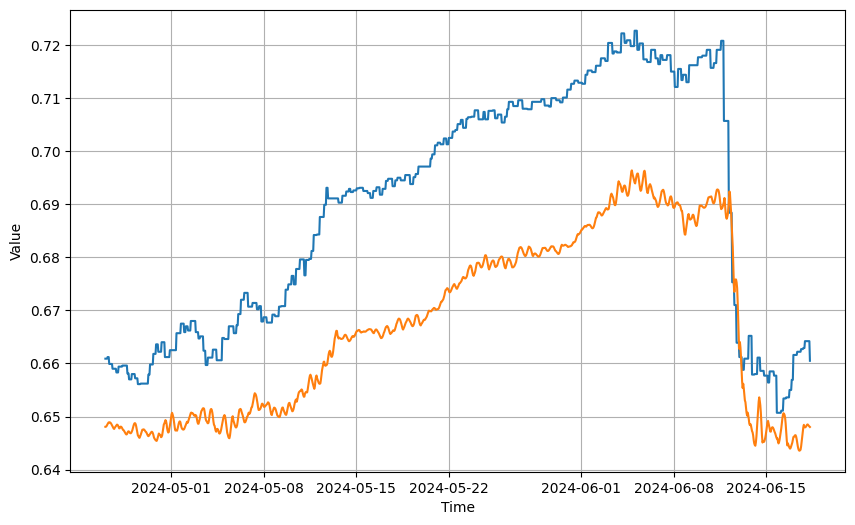

In [58]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [59]:
# Compute the MSE and MAE
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.00055105856
0.02222483


0.0009153854
0.02462398